In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

2022-10-31 21:19:00.584615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
training_data = pd.read_csv("disaster_dataset/train.csv")
testing_data = pd.read_csv("disaster_dataset/test.csv")

In [3]:
training_data.sample(2)

,id,keyword,location,text,target
6170,8800,sirens,828??864??803,@_DANGdaddy the sirens are telling you to get ...,0
6795,9734,tragedy,Canada,DTN India: Rly tragedy in MP: Some live to rec...,1


In [4]:
training_data['text'].isnull().sum()

0

- Text preprocessing 

In [5]:
#Convert the entire text into lower case
training_data['new_text'] = training_data['text'].apply(lambda x:x.lower())

In [6]:
#Perform Lemmatization
lemm=WordNetLemmatizer()

In [9]:
nltk.download('wordnet')
nltk.download('omw-1.4')
training_data['new_text'] = training_data['new_text'].apply(lambda x:lemm.lemmatize(x))

[nltk_data] Downloading package wordnet to /Users/tdoan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/tdoan/nltk_data...


In [10]:
#Remove StopWords
stop_words = stopwords.words("english")

def remove_stopwords(text):
    no_stop = []
    for word in text.split(' '):
        if word not in stop_words:
            no_stop.append(word)
    return " ".join(no_stop)

In [11]:
training_data['new_text'] = training_data['new_text'].apply(remove_stopwords)

In [12]:
#Remove unwanted text- Text Cleaning
def clean_text(text):
    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'https?://[^\s\n\r]+', '', text)
    text = re.sub(r'#', '', text)
    return text

In [13]:
training_data['new_text'] = training_data['new_text'].apply(clean_text)

In [14]:
# Removes all punctuation from a string, if present
def remove_punctuation_func(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

In [15]:
training_data['new_text'] = training_data['new_text'].apply(remove_punctuation_func)

In [16]:
training_data.sample(5)

,id,keyword,location,text,target,new_text
2275,3263,demolish,NaN,@kirkmin after listening to you demolish @Bart...,0,kirkmin listening demolish barthubbuch weei...
7212,10331,weapon,"New York, NY",03/08/11: Police stop a 41-year-old in the Bro...,1,03 08 11 police stop 41 year old bronx citing...
4285,6088,hellfire,NaN,Hellfire is surrounded by desires so be carefu...,0,hellfire surrounded desires careful don t le...
4583,6516,injuries,California or Colorado,Why is #GOP blocking chance for #DisabledVeter...,0,gop blocking chance disabledveterans w groin ...
6202,8852,smoke,NaN,IM GONNA GET NAKED AND SMOKE MY CIGARETTE some...,0,im gonna get naked smoke cigarette someone cal...


- Define Feature and Target to train a model

In [17]:
X = training_data['new_text']

In [18]:
y = training_data['target']

In [19]:
np.unique(y)

array([0, 1])

- Text Preparation to train Model

In [20]:
token = Tokenizer(num_words=10000,oov_token="<OOV>")

In [21]:
token.fit_on_texts(X)

In [22]:
word_index = token.word_index

In [23]:
training_seq = token.texts_to_sequences(X)

In [24]:
train_padded = pad_sequences(training_seq,padding="post",truncating="post",maxlen=50)

- Split the Data into Training and Validation

In [25]:
X_train,X_valid,y_train,y_valid = train_test_split(train_padded,y,test_size=0.2,train_size=0.8)

- LSTM

In [26]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(10000,128))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64,return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
model.add(keras.layers.Dense(128,activation="relu"))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(1,activation="sigmoid"))

2022-10-31 21:32:37.042806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
model.compile("rmsprop", "binary_crossentropy", metrics=["accuracy"])

In [28]:
history = model.fit(X_train,y_train,epochs=5,validation_data=(X_valid,y_valid))

Epoch 1/5
191/191 [==============================] - 35s 138ms/step - loss: 0.5305 - accuracy: 0.7358 - val_loss: 0.4679 - val_accuracy: 0.7820
Epoch 2/5
191/191 [==============================] - 25s 131ms/step - loss: 0.3675 - accuracy: 0.8450 - val_loss: 0.4343 - val_accuracy: 0.8070
Epoch 3/5
191/191 [==============================] - 25s 132ms/step - loss: 0.3126 - accuracy: 0.8783 - val_loss: 0.4541 - val_accuracy: 0.8004
Epoch 4/5
191/191 [==============================] - 24s 124ms/step - loss: 0.2701 - accuracy: 0.8992 - val_loss: 0.4846 - val_accuracy: 0.7932
Epoch 5/5
191/191 [==============================] - 24s 125ms/step - loss: 0.2255 - accuracy: 0.9179 - val_loss: 0.5192 - val_accuracy: 0.7859


- Visualize Loss and Accuracy Tradeoff

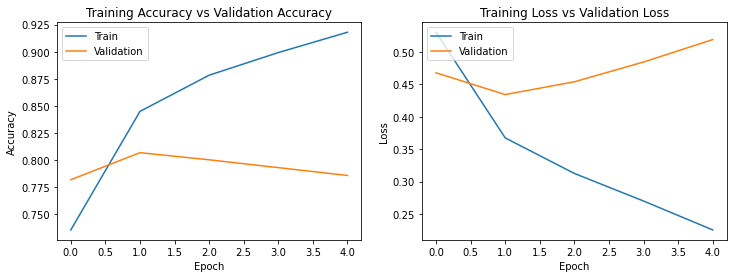

In [29]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

- Predict on Testing Data

In [30]:
testing_seq = token.texts_to_sequences(testing_data['text'])

In [31]:
test_padded = pad_sequences(testing_seq,padding="post",truncating="post",maxlen=50)

In [32]:
pred = model.predict(test_padded)

102/102 [==============================] - 4s 23ms/step


In [33]:
len(pred)

3263

In [34]:
test_prediction = []
for i in pred:
    if i[0]>0.5:
        test_prediction.append(1)
    else:
        test_prediction.append(0)

In [35]:
testing_data['target'] = test_prediction

In [36]:
testing_data.sample(5)

,id,keyword,location,text,target
187,602,arsonist,ss,mo the way she says 'carry' https://t.co/vQzRU...,0
2304,7705,panicking,NaN,Need stop panicking when I'm driving and peopl...,0
257,831,bioterror,NaN,FedEx no longer to transport bioterror germs i...,0
3199,10634,wounded,Mii Facebook,Police Officer Wounded Suspect Dead After Exch...,1
1241,4073,displaced,U.S.,#Myanmar Displaced #Rohingya at #Sittwe point...,1
